# I'm Something of a Painter Myself - Use GANs to create art - 

## 1. Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip install tensorflow-addons
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import re

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

D0430 07:24:33.269788202      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0430 07:24:33.269818892      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0430 07:24:33.269822741      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0430 07:24:33.269825289      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0430 07:24:33.269827572      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0430 07:24:33.269830299      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0430 07:24:33.269832594      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0430 07:24:33.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 KB 9.2 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


/usr/local/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Number of replicas: 8
2.12.0


## 2. Data preparation

In [2]:
#gcs_path = KaggleDatasets().get_gcs_path()
gcs_path = '/kaggle/input/gan-getting-started'

In [3]:
monet_filenames = tf.io.gfile.glob(str(gcs_path + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(monet_filenames))

photo_filenames = tf.io.gfile.glob(str(gcs_path + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(photo_filenames))

monet_sample = np.sum([int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in monet_filenames])
print('Monet Images:', monet_sample)

photo_sample = np.sum([int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in photo_filenames])
print('Photo Images:', photo_sample)

Monet TFRecord Files: 5
Photo TFRecord Files: 20
Monet Images: 300
Photo Images: 7038


### All images prepared for competition are set to 256 * 256. Due to RGB images, channels are set to 3. Also, all the images are normalized to [-1,1] scale through "decode_image" function.

In [4]:
IMAGE_SIZE = [256, 256]


def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image


def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [5]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    
    return dataset

### - Load & view the data

In [6]:
monet_ds = load_dataset(monet_filenames, labeled=True).batch(1)
photo_ds = load_dataset(photo_filenames, labeled=True).batch(1)

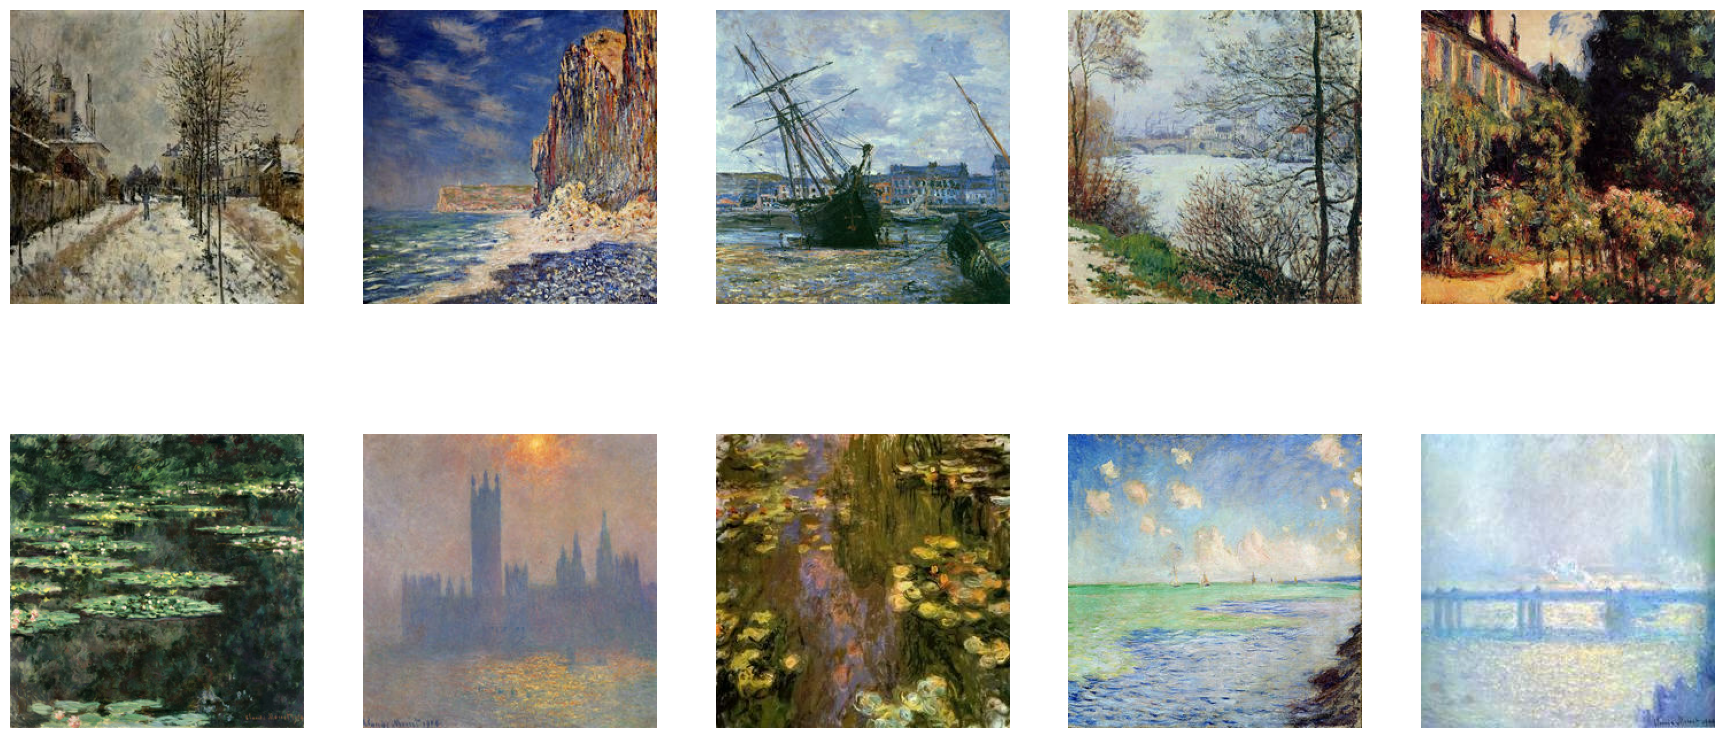

In [7]:
def view_image(ds, rows=2):
    image = iter(ds)
    plt.figure(figsize=(22, rows * 5.05 ))
    for i in range(5 * rows):
        temp = next(image)
        plt.subplot(2,5,i + 1)
        plt.axis('off')
        plt.imshow(temp[0] / 2 + .5)

view_image(monet_ds)

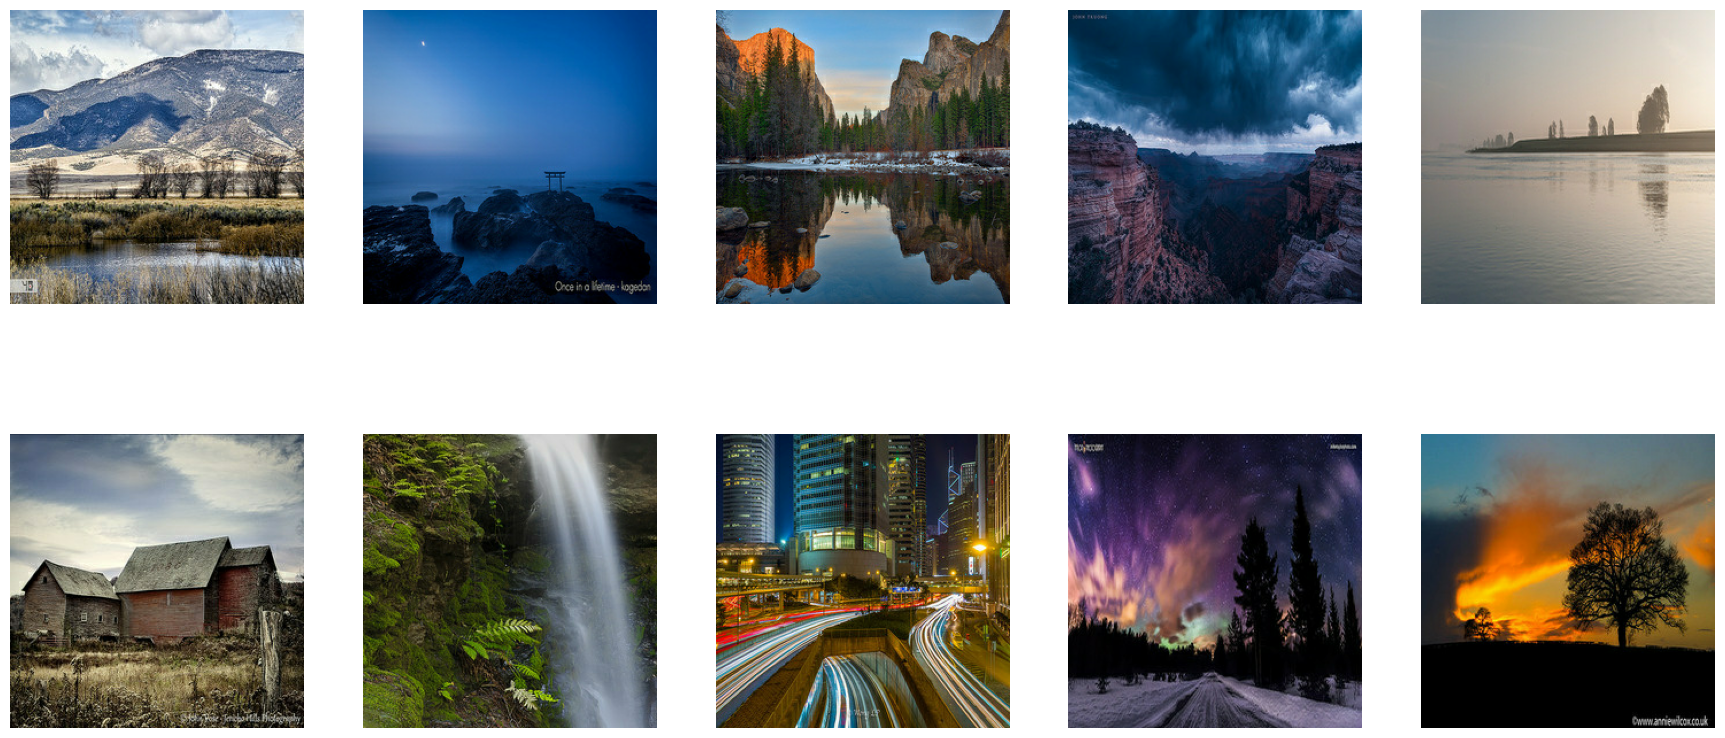

In [8]:
view_image(photo_ds)

In [9]:
print(next(iter(monet_ds)).shape)
print(next(iter(photo_ds)).shape)

(1, 256, 256, 3)
(1, 256, 256, 3)


### - Size of the data set:  (1, 256, 256, 3). 

## 3. Modelling - CycleGAN -

### (1) Build generator

### UNET architecture is used for our CycleGAN. In order for this architecture, "downsample" and "upsample" should be defined.
###  "Downsample" reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

### We use an instance normalization instead of batch normalizarion, because we took the batch size as 1 in advance.

In [10]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

### "Upsample" increases the dimensions of the of the image. 

In [11]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

### Build Generator
### "downsample" -> skip connection -> "upsample"

In [12]:
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4),                          # (bs, 64, 64, 128)
        downsample(256, 4),                          # (bs, 32, 32, 256)
        downsample(512, 4),                          # (bs, 16, 16, 512)
        downsample(512, 4),                          # (bs, 8, 8, 512)
        downsample(512, 4),                          # (bs, 4, 4, 512)
        downsample(512, 4),                          # (bs, 2, 2, 512)
        downsample(512, 4),                          # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4),                     # (bs, 16, 16, 1024)
        upsample(256, 4),                     # (bs, 32, 32, 512)
        upsample(128, 4),                     # (bs, 64, 64, 256)
        upsample(64, 4),                      # (bs, 128, 128, 128)
    ]

    
    
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### (2) Build Discriminator
### "Discriminator" classifies the input image as real or fake.

In [13]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1,4,1,kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [14]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

### (3) Define LOSS function

In [15]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)    
    
   
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1
    
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss    

### (4) Build CycleGAN model

In [16]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        batch_size = tf.shape(real_photo)[0] #
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### (5) Train CycleGAN

In [17]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    Gan_model_1 = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    Gan_model_1.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [18]:
history = Gan_model_1.fit(tf.data.Dataset.zip((monet_ds, photo_ds)),epochs=20, verbose = 2).history

Epoch 1/20


2023-04-30 07:26:17.261165: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-04-30 07:26:18.907537: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


300/300 - 167s - monet_gen_loss: 4.0365 - photo_gen_loss: 3.8245 - monet_disc_loss: 0.6245 - photo_disc_loss: 0.6902 - 167s/epoch - 557ms/step
Epoch 2/20
300/300 - 38s - monet_gen_loss: 3.8866 - photo_gen_loss: 3.4515 - monet_disc_loss: 0.6863 - photo_disc_loss: 0.9809 - 38s/epoch - 127ms/step
Epoch 3/20
300/300 - 38s - monet_gen_loss: 3.7467 - photo_gen_loss: 3.7161 - monet_disc_loss: 0.6905 - photo_disc_loss: 0.6461 - 38s/epoch - 127ms/step
Epoch 4/20
300/300 - 38s - monet_gen_loss: 3.4240 - photo_gen_loss: 3.8122 - monet_disc_loss: 0.6405 - photo_disc_loss: 0.5309 - 38s/epoch - 126ms/step
Epoch 5/20
300/300 - 38s - monet_gen_loss: 3.2956 - photo_gen_loss: 3.4680 - monet_disc_loss: 0.6587 - photo_disc_loss: 0.6201 - 38s/epoch - 127ms/step
Epoch 6/20
300/300 - 38s - monet_gen_loss: 3.0604 - photo_gen_loss: 3.2447 - monet_disc_loss: 0.6782 - photo_disc_loss: 0.7249 - 38s/epoch - 127ms/step
Epoch 7/20
300/300 - 38s - monet_gen_loss: 3.1144 - photo_gen_loss: 3.2976 - monet_disc_loss: 0.7

### (6) Visualize generated photos

In [19]:
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        temp = next(ds_iter)
        generated_temp = model.predict(temp)
        
        plt.subplot(121)
        plt.title("input image")
        plt.imshow(temp[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_temp[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

2023-04-30 07:40:15.566231: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-04-30 07:40:15.673431: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 7s 7s/step


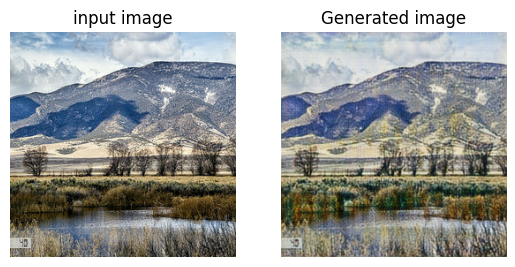

1/1 [==============================] - 1s 507ms/step


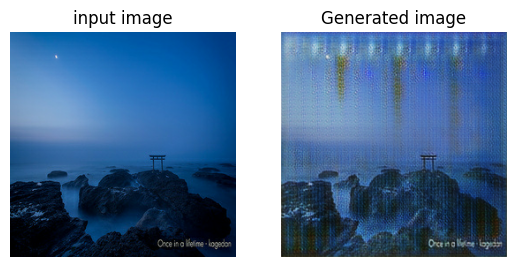

1/1 [==============================] - 1s 502ms/step


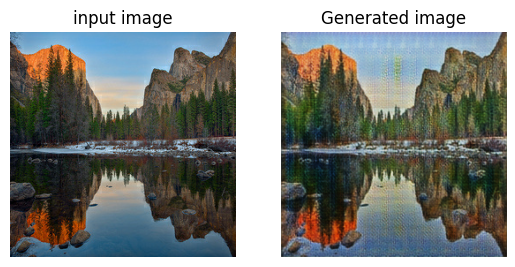

1/1 [==============================] - 0s 498ms/step


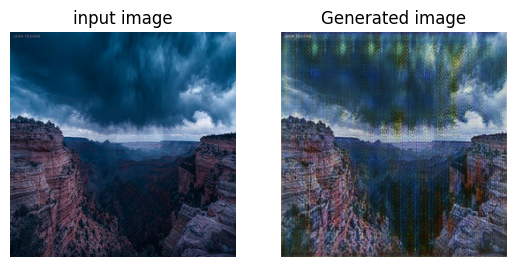

In [20]:
display_generated_samples(load_dataset(photo_filenames).batch(1), monet_generator, 4)

### (7) Parameter tuning
### Generated images seem not to be well transposed by using Monet images. The background is that the number of iteration would be small (epochs is set to 20). In order to increase the learning effect, the epochs are increased to 50.

In [21]:
history = Gan_model_1.fit(tf.data.Dataset.zip((monet_ds, photo_ds)),epochs=50, verbose = 2).history

Epoch 1/50
300/300 - 38s - monet_gen_loss: 2.5612 - photo_gen_loss: 2.8615 - monet_disc_loss: 0.8249 - photo_disc_loss: 0.6296 - 38s/epoch - 128ms/step
Epoch 2/50
300/300 - 38s - monet_gen_loss: 2.7210 - photo_gen_loss: 2.9551 - monet_disc_loss: 0.8560 - photo_disc_loss: 0.6599 - 38s/epoch - 128ms/step
Epoch 3/50
300/300 - 38s - monet_gen_loss: 2.6892 - photo_gen_loss: 2.8844 - monet_disc_loss: 0.8332 - photo_disc_loss: 0.6627 - 38s/epoch - 126ms/step
Epoch 4/50
300/300 - 38s - monet_gen_loss: 2.7086 - photo_gen_loss: 2.8980 - monet_disc_loss: 0.8814 - photo_disc_loss: 0.6798 - 38s/epoch - 126ms/step
Epoch 5/50
300/300 - 38s - monet_gen_loss: 2.5244 - photo_gen_loss: 2.7248 - monet_disc_loss: 0.8418 - photo_disc_loss: 0.6979 - 38s/epoch - 127ms/step
Epoch 6/50
300/300 - 38s - monet_gen_loss: 2.5092 - photo_gen_loss: 2.6769 - monet_disc_loss: 0.8386 - photo_disc_loss: 0.6919 - 38s/epoch - 126ms/step
Epoch 7/50
300/300 - 38s - monet_gen_loss: 2.6593 - photo_gen_loss: 2.7371 - monet_disc_

1/1 [==============================] - 1s 538ms/step


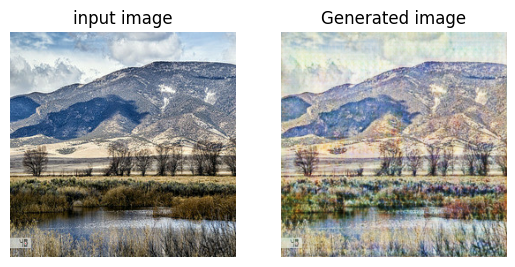

1/1 [==============================] - 1s 516ms/step


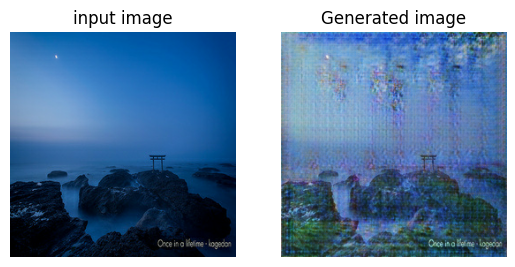

1/1 [==============================] - 1s 553ms/step


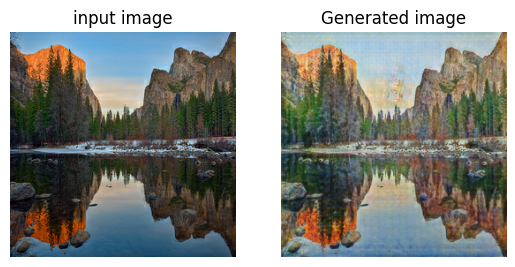

1/1 [==============================] - 1s 543ms/step


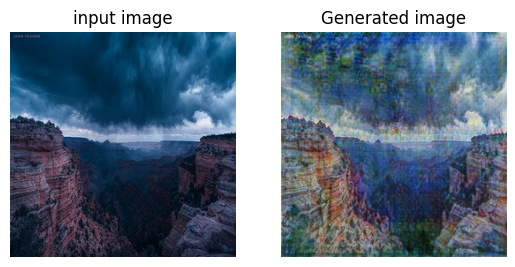

In [22]:
display_generated_samples(load_dataset(photo_filenames).batch(1), monet_generator, 4)

### (8) Save and make submission file

In [23]:
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

In [24]:
import os, PIL
os.makedirs('../images/') # Create folder to save generated images

predict_and_save(load_dataset(photo_filenames).batch(1), monet_generator, '../images/')

In [25]:
import shutil
shutil.make_archive("/kaggle/working/images",'zip',"/kaggle/images")

'/kaggle/working/images.zip'

## 4. Additional modelling - Deep Convolutional GAN -

### Based on the CycleGAN, we try to remodel this model to deep convolutional GAN.

In [26]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import ReLU, LeakyReLU, Activation
import time

In [27]:
OUTPUT_CHANNELS = 3

def downsample2(filters, size, activation, apply_dropout=False, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    
    if activation == 'leakyrelu':
        result.add(layers.LeakyReLU())
    elif activation == 'relu':
        result.add(layers.ReLU())

    return result

In [28]:
def upsample2(filters, size, activation, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))
        
    if activation == 'leakyrelu':
        result.add(layers.LeakyReLU())
    elif activation == 'relu':
        result.add(layers.ReLU())
        
    return result

In [29]:
def Generator2():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample2(64, 4,"leakyrelu", apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample2(128, 4, "leakyrelu"),                          # (bs, 64, 64, 128)
        downsample2(256, 4, "leakyrelu"),                          # (bs, 32, 32, 256)
        downsample2(512, 4, "leakyrelu"),                          # (bs, 16, 16, 512)
        downsample2(512, 4, "leakyrelu"),                          # (bs, 8, 8, 512)
        downsample2(512, 4, "leakyrelu"),                          # (bs, 4, 4, 512)
        downsample2(512, 4, "leakyrelu"),                          # (bs, 2, 2, 512)
        downsample2(512, 4, "leakyrelu"),                          # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample2(512, 4,"relu", apply_dropout=True), # (bs, 2, 2, 1024)
        upsample2(512, 4, "relu", apply_dropout=True), # (bs, 4, 4, 1024)
        upsample2(512, 4, "relu", apply_dropout=True), # (bs, 8, 8, 1024)
        upsample2(512, 4, "relu"),                     # (bs, 16, 16, 1024)
        upsample2(256, 4, "relu"),                     # (bs, 32, 32, 512)
        upsample2(128, 4, "relu"),                     # (bs, 64, 64, 256)
        upsample2(64, 4, "relu"),                      # (bs, 128, 128, 128)
    ]

    
    
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [30]:
def Discriminator2():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample2(64, 4, "leakyrelu",False)(x) # (bs, 128, 128, 64)
    down2 = downsample2(128, 4, "leakyrelu")(down1) # (bs, 64, 64, 128)
    down3 = downsample2(256, 4, "leakyrelu")(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)


    last_conv = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    last_relu = layers.LeakyReLU(alpha=0.2)(last_conv)
    last_pool = layers.Flatten()(last_relu)
    last = layers.Dense(1, activation = 'sigmoid')(last_pool)

    return tf.keras.Model(inputs=inp, outputs=last)

In [31]:
with strategy.scope():
    monet_generator = Generator2() # transforms photos to Monet-esque paintings
    photo_generator = Generator2() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator2() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator2() # differentiates real photos and generated photos

In [32]:
with strategy.scope():
    def discriminator_loss(real, generated):
        loss1 = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real),real)

        loss2 = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = loss1 + loss2

        return total_disc_loss * 0.5
    
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1
    
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss    

In [33]:
class CycleGan2(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
        label_real = 0.5
    ):
        super(CycleGan2, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.label_real = label_real
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan2, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        batch_size = tf.shape(real_photo)[0]
        label_real = tf.zeros((batch_size,1)) + self.label_real
        label_real += 0.05 * tf.random.uniform(tf.shape(label_real))
        
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [34]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    Gan_model_2 = CycleGan2(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    Gan_model_2.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [35]:
history = Gan_model_2.fit(tf.data.Dataset.zip((monet_ds, photo_ds)),epochs=50, verbose = 2).history

Epoch 1/50


/usr/local/lib/python3.8/site-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-04-30 08:43:13.568086: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-04-30 08:43:15.131444: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


300/300 - 171s - monet_gen_loss: 3.6695 - photo_gen_loss: 4.1254 - monet_disc_loss: 0.7753 - photo_disc_loss: 0.6624 - 171s/epoch - 569ms/step
Epoch 2/50
300/300 - 39s - monet_gen_loss: 3.4343 - photo_gen_loss: 3.9438 - monet_disc_loss: 0.7937 - photo_disc_loss: 0.6510 - 39s/epoch - 131ms/step
Epoch 3/50
300/300 - 39s - monet_gen_loss: 3.6533 - photo_gen_loss: 3.8291 - monet_disc_loss: 0.7509 - photo_disc_loss: 0.6406 - 39s/epoch - 131ms/step
Epoch 4/50
300/300 - 39s - monet_gen_loss: 3.7105 - photo_gen_loss: 3.6956 - monet_disc_loss: 0.8905 - photo_disc_loss: 0.7080 - 39s/epoch - 131ms/step
Epoch 5/50
300/300 - 39s - monet_gen_loss: 3.4175 - photo_gen_loss: 3.5609 - monet_disc_loss: 0.9697 - photo_disc_loss: 0.6778 - 39s/epoch - 131ms/step
Epoch 6/50
300/300 - 39s - monet_gen_loss: 3.3393 - photo_gen_loss: 3.5080 - monet_disc_loss: 0.9892 - photo_disc_loss: 0.6738 - 39s/epoch - 131ms/step
Epoch 7/50
300/300 - 39s - monet_gen_loss: 3.3040 - photo_gen_loss: 3.5661 - monet_disc_loss: 1.0

2023-04-30 09:17:27.337822: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-04-30 09:17:27.436973: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 8s 8s/step


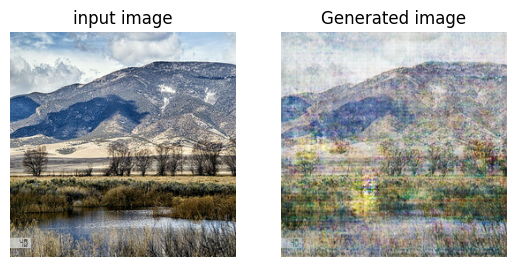

1/1 [==============================] - 1s 505ms/step


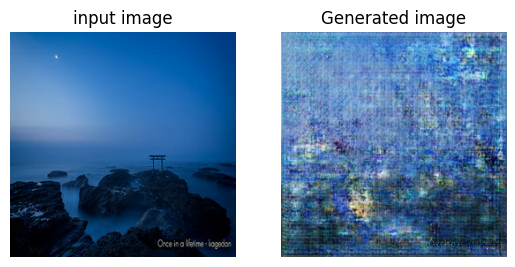

1/1 [==============================] - 1s 501ms/step


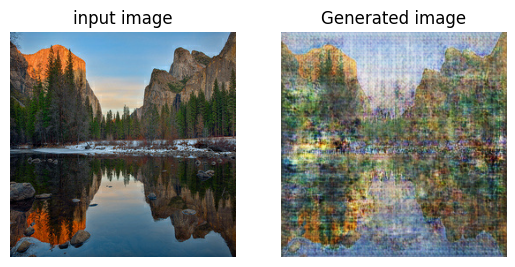

1/1 [==============================] - 0s 497ms/step


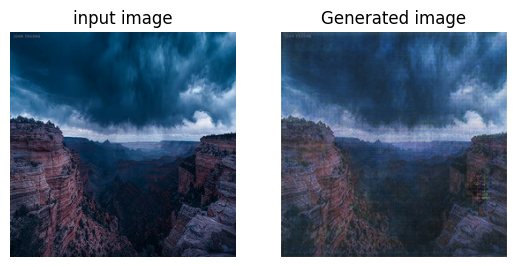

In [36]:
display_generated_samples(load_dataset(photo_filenames).batch(1), monet_generator, 4)

In [37]:
#import os, PIL
#os.makedirs('../images/') # Create folder to save generated images

#predict_and_save(load_dataset(photo_filenames).batch(1), monet_generator, '../images/')

In [38]:
#import shutil
#shutil.make_archive("/kaggle/working/images",'zip',"/kaggle/images")

## 5. Analysis
### - At the CycleGAN model, it is confirmed that the number of epochs is closely related to the result, "monet-esque" level of the generated images.
### - Compared with CycleGAN model (epochs = 50), the generated images produced by the Deep Convolution GAN (epochs = 50) could seem more "monet-esque", but could be estimated a little blurred. Earlystopping might be necessary. In this respect, the score of the Kaggle is worse (CycleGAN: 57.89375, DCGAN: 78.21363). 
### - The effect of Deep Convolution GAN is straightforward, so that the fine tuning of hyperparameter such as epoch, the parameter of Adam (learning rate, beta_1, beta_2, etc) would be necessary for better performance.

## 6. Conclusion
### In this project, CycleGAN and DCGAN are adopted for generating images by using Monet images. The score of Kaggle at the CycleGAN (epochs = 50) is the best among tried 3 models. 
### There would be some room for improving performance by tuning hyperparameter such as # of epochs, Adam parameters. Also two-objective discriminator might be effective; this is a intereting issue to be tackled in the future.

### Reference
#### https://www.kaggle.com/competitions/gan-getting-started/
#### https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
#### https://www.kaggle.com/code/thuylinh225/generate-monet-images-using-dcgan
#### https://www.kaggle.com/code/dimitreoliveira/introduction-to-cyclegan-monet-paintings
#### https://www.kaggle.com/code/unfriendlyai/two-objective-discriminator
#### https://www.kaggle.com/code/huanguyen/dcgan-based-cyclegan